**Instructors**: Prof. Keith Chugg (chugg@usc.edu)

**Notebook**: Written by PhD student Hassan Hammad from Prof. Chugg's group.

# Multiclass Classifier for FMNIST Using Logistic Regression in PyTorch

In this notebook, we will use PyTorch to train an ANN/MLP for the FMNIST dataset.  There are many variations, but this is a good template to use for PyTorch training of neural networks.

This notebook requires torch to be installed. To install this, use `pip3 install torch torchvision torchaudio`. This will work on Nvidia GPU, as well as on an M1/M2 Apple chip. You also need to install `tqdm` which is a package used to provide training progress results.

In [13]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Accessing the Data
First, let's get the data. Torchvision provides many built-in datasets including Fashion MNIST. Fashion MNIST is a dataset of 28x28 images of fashion items.

In [14]:
# All datasets are subclasses of torch.utils.data.Dataset i.e, they have __getitem__ and __len__ methods implemented
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) # transforms.ToTensor() converts the image to a tensor and transforms.Normalize() normalizes the tensor
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [15]:
testset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [16]:
image, label = trainset[0] 
print(image.shape) # torch.Size([1, 28, 28])
print(label) 

torch.Size([1, 28, 28])
9


Fashion MNIST dataset comes as train and test sets, of sizes 60,000 and 10,000 respectively.
If we want to use a validation set, we need to create it manually

In [17]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
# Final sizes are 50000, 10000, 10000
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}, Test set size: {len(testset)}')

Train set size: 50000, Validation set size: 10000, Test set size: 10000


In PyTorch, data is loaded using data loaders, which are iterators over the dataset.
Data Loaders need a batch size, which is the size of the data batch extracted in each iteration.
We will create a dataloader for each data split.

In [18]:
batchsize = 32
# Shuffle the data at the start of each epoch (only useful for training set)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

#Model Definition
Create a Logistic Regression (1-layer neural network). In Pytorch, `nn.Module` is the base class for all neural network modules in PyTorch.
Your models should also subclass this class

In [19]:
# Parameters for the model
n_pixels = 28 * 28
n_classes = 10

# Define the model
class MiltiClassLogistic(nn.Module):
    def __init__(self, n_pixels, n_classes): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_pixels, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        a0 = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        a1 = self.fc1(a0)
        return a1 # note: no softmax, as this is included in the loss function in PyTorch
    
model = MiltiClassLogistic(n_pixels, n_classes)
print(model)

MiltiClassLogistic(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


For multi-class classification, we use the cross entropy loss function. In pytorch, the input to `nn.CrossEntropyLoss` should be logits not probabilities. The loss function combines softmax with loss calculation for numerical stability. For the optimizer algorithm, we will use Adam, a very popular optimizer.

In [20]:
lr = 1e-2   ## the learning rate in TF is part of the optimizer.  Default is 1e-2
reg_val = 0  # L2 regularizer value -- 1e-4 is common
criterion = nn.CrossEntropyLoss() # includes softmax (for numerical stability)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg_val)

In [22]:
# set the device to use and move model to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

device = torch.device("cpu")
print(f'Using device: {device}')
model.to(device) # Move model to device

Using device: cpu


MiltiClassLogistic(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

# Training the Model
Unlike Keras, in Pytorch we need to explicitly write the training functions. This includes iterating over data batches, forward and backward passes, loss caluclation and updating the weights.
We will write two functions. One for trianing loops (to update the weights of the model) and one for validation loop (to evaluate performance).

In [23]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (images, labels) in enumerate(trainloader): # Iterate over batches
            images, labels = images.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(images) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels).float().mean().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [24]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (images, labels) in enumerate(valloader): # Iterate over batches
                images, labels = images.to(device), labels.to(device) # Move batch to device
                output = model(images) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item() 
                running_acc += (output.argmax(1) == labels).float().mean().item()
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

Finally we loop over the number of epochs. In each epoch we loop once over the training dataset and update the model weights. Then we loop once over the validation dataset and calculate validation loss and accuracy. We will use tqdm to display the progress bar. We also save the model that acheived the best validation accuracy across all epochs.

 Note: the training loss/acc displayed are running averages during training while the validation loss/acc are computed after training epoch is finished. This is why val loss might be lower than training loss in the first few epochs. To compare train vs val peformance on the same model, we can recompute training loss/acc after epoch is finished. This takes extra time so we usually ignore it

In [25]:
# Run training and validation loop
# Save the best model based on validation accuracy
n_epochs = 20
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epochs): # Iterate over epochs
    print(f"Epoch {epoch+1} of {n_epochs}")
    train_loss, train_acc  = train(model, trainloader, criterion, optimizer, device) # Train
    val_loss, val_acc = validate(model, valloader, criterion, device) # Validate
    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)
    if val_acc > best_acc: # Save best model
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt") # saving model parameters ("state_dict") saves memory and is faster than saving the entire model

Epoch 1 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 309.87batch/s, loss=0.658, acc=81.9]


Epoch 2 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 319.12batch/s, loss=0.646, acc=83.2]


Epoch 3 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 294.07batch/s, loss=0.664, acc=84.1]


Epoch 4 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 284.50batch/s, loss=0.637, acc=84.5]


Epoch 5 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 334.72batch/s, loss=0.624, acc=84.6]


Epoch 6 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 322.83batch/s, loss=0.598, acc=84.9]


Epoch 7 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 312.07batch/s, loss=0.621, acc=85]  


Epoch 8 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 322.56batch/s, loss=0.634, acc=84.8] 


Epoch 9 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 328.01batch/s, loss=0.664, acc=84.8]


Epoch 10 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 328.04batch/s, loss=0.587, acc=85]  


Epoch 11 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 291.48batch/s, loss=0.576, acc=85.3] 


Epoch 12 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 323.15batch/s, loss=0.605, acc=85.4]


Epoch 13 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 275.17batch/s, loss=0.63, acc=84.9]  


Epoch 14 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 329.49batch/s, loss=0.587, acc=85.4]


Epoch 15 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 303.44batch/s, loss=0.554, acc=85.5] 


Epoch 16 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 311.82batch/s, loss=0.548, acc=85.6] 


Epoch 17 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 320.49batch/s, loss=0.576, acc=85.5]


Epoch 18 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 330.23batch/s, loss=0.637, acc=84.5]


Epoch 19 of 20


Eval: 100%|██████████| 313/313 [00:01<00:00, 295.56batch/s, loss=0.588, acc=85.7] 


Epoch 20 of 20


Eval: 100%|██████████| 313/313 [00:00<00:00, 325.61batch/s, loss=0.571, acc=85.5] 


# Visualizing the Training/Validation (Learning Curves)

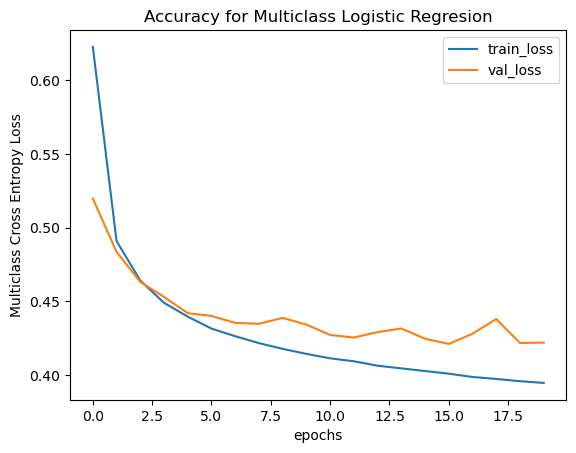

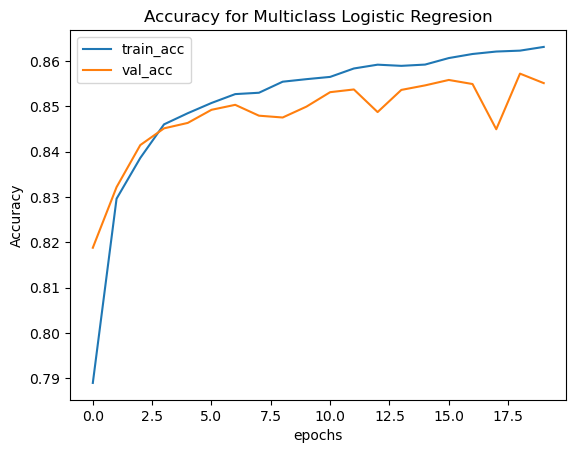

In [26]:
epochs = torch.arange(n_epochs)

# plot training and validation loss
plt.figure()
plt.plot(epochs, train_loss_history, label='train_loss')
plt.plot(epochs, val_loss_history, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('Multiclass Cross Entropy Loss')
plt.title(f'Accuracy for Multiclass Logistic Regresion')
plt.legend()

# plot training and validation accuracy
plt.figure()
plt.plot(epochs, train_acc_history, label='train_acc')
plt.plot(epochs, val_acc_history, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy for Multiclass Logistic Regresion')
plt.legend()


# Evaluating on the Test Data

In [27]:
# Load the best model and evaluate on test set
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = validate(model, testloader, criterion, device)
print(f"Test accuracy: {test_acc:.4f}")

Eval: 100%|██████████| 313/313 [00:00<00:00, 331.22batch/s, loss=0.355, acc=84.2]

Test accuracy: 0.8424


Perform inference on a single image form the test set.  In PyTorch, when doing inference, the model should be put in `.eval()` mode and you should use the `with torch.no_grad()` statement.  For more complex networks, the `.eval()` configures the layers to be in inference mode (e.g., a dropout layer needs to be configured for training or inference) and the `with torch.no_grad()` ensures that the gradient is not be tracked.  

Test Image Number: 8516
Predicted Class: Trouser
Actual Class: Trouser


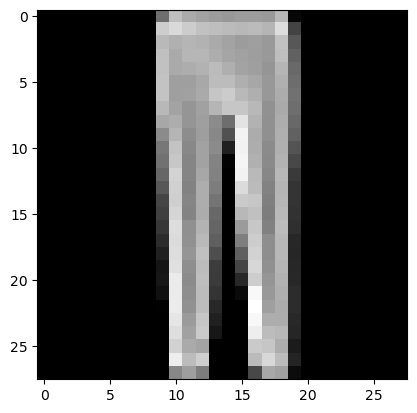

In [34]:
model.eval()  # Set model to evaluation mode
img = np.random.randint(len(testset))  # Ensure valid index

with torch.no_grad():
    image, label = testset[img]  # Get image and label
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    
    output = model(image)  # Forward pass

pred = output.argmax(1)  # Get predicted class index

# Print results
print(f"Test Image Number: {img}")
print(f"Predicted Class: {testset.classes[pred.item()]}")
print(f"Actual Class: {testset.classes[label]}")  # Access actual label

# Plot image
plt.figure()
plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')  # Ensure correct shape
plt.show()
